In [ ]:
!pip install yfinance
!pip install arch
!pip install wrds
!pip install refinitiv-data
!pip install eikon


In [2]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from arch import arch_model
import wrds
import eikon as ek
import datetime as dt

c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Are Inflation and Volatility Orthogonal? 

In [3]:
fred = Fred(api_key='6b4eeb7bacf916c9917c8a74feb0921c')

# Download U.S. CPI data (monthly) from FRED
cpi_data = fred.get_series('CPIAUCSL', observation_start='1978-12-31', observation_end='2024-12-31')

# Convert the CPI data to a DataFrame and set the date as index
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])
cpi_df.index = pd.to_datetime(cpi_df.index)

# Calculate the monthly inflation rate
cpi_df['Monthly Inflation Rate'] = cpi_df['CPI'].pct_change() * 100

# Resample to monthly frequency
cpi_df = cpi_df.resample('M').mean()

# Drop any missing values
cpi_df.dropna(inplace=True)

print(cpi_df.head())

             CPI  Monthly Inflation Rate
1979-01-31  68.5                0.883652
1979-02-28  69.2                1.021898
1979-03-31  69.9                1.011561
1979-04-30  70.6                1.001431
1979-05-31  71.4                1.133144


C:\Users\geral\AppData\Local\Temp\ipykernel_15740\4172750302.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cpi_df = cpi_df.resample('M').mean()


In [4]:
# Calculate Year-over-Year (YoY) inflation rate
cpi_df['YoY Inflation Rate'] = cpi_df['CPI'].pct_change(periods=12) * 100

# Drop any missing values from the YoY calculation
cpi_df.dropna(inplace=True)

print(cpi_df.head())

             CPI  Monthly Inflation Rate  YoY Inflation Rate
1980-01-31  78.0                1.430429           13.868613
1980-02-29  79.0                1.282051           14.161850
1980-03-31  80.1                1.392405           14.592275
1980-04-30  80.9                0.998752           14.589235
1980-05-31  81.7                0.988875           14.425770


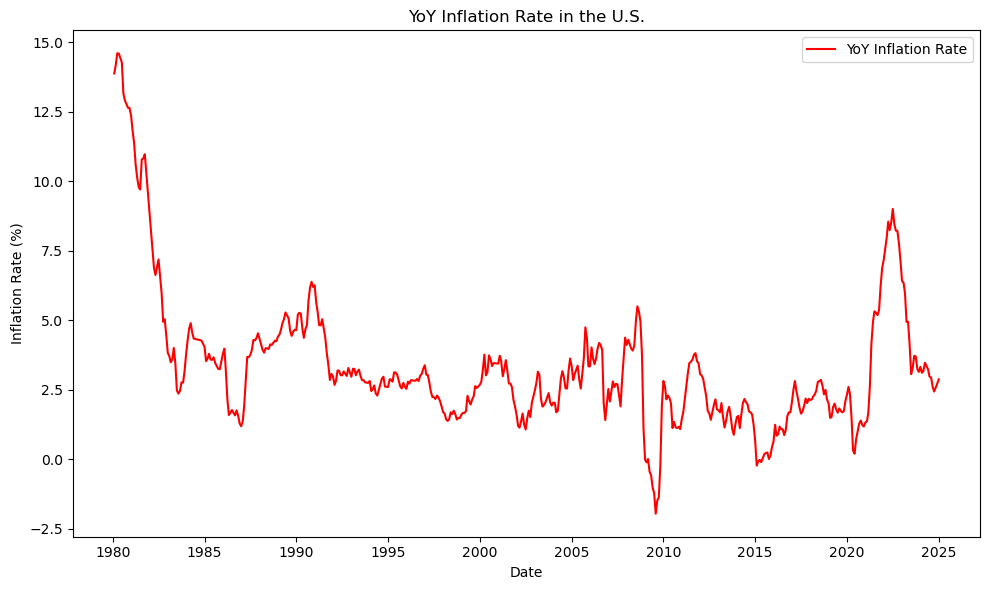

In [5]:
# Plot Monthly Inflation Rate and YoY Inflation Rate
plt.figure(figsize=(10, 6))

# Plot YoY Inflation Rate
plt.plot(cpi_df.index, cpi_df['YoY Inflation Rate'], color='red', label='YoY Inflation Rate')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('YoY Inflation Rate in the U.S.')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
# Set your Eikon API key
ek.set_app_key('61899440ebae4092ba26deecaf92f2da82521286')

# Define the MSCI World Index RIC (Example: '.dMIWO00000PUS')
msci_ric = '.dMIWO00000PUS'

# Fetch historical monthly data from 1980 to 2024
msci_world = ek.get_timeseries(msci_ric, start_date='1979-12-01', end_date='2024-12-31', interval='monthly')

# Keep only the closing price column
msci_world.rename(columns={'CLOSE': 'Price'}, inplace=True)

# Calculate Monthly Returns
msci_world['Returns'] = msci_world['Price'].pct_change() * 100

# Display first few rows
print(msci_world.head())

.dMIWO00000PUS     Price  HIGH   LOW  OPEN    Returns
Date                                                 
1979-12-31      131.1009  <NA>  <NA>  <NA>       <NA>
1980-01-31       138.591  <NA>  <NA>  <NA>   5.713233
1980-02-29      138.2481  <NA>  <NA>  <NA>  -0.247419
1980-03-31      122.9586  <NA>  <NA>  <NA> -11.059465
1980-04-30      130.5814  <NA>  <NA>  <NA>   6.199485


In [7]:
# Keep only the returns column
msci_world = msci_world[['Returns']]

# Calculate Cumulative Returns
msci_world['Cumulative Returns'] = (1 + msci_world['Returns'] / 100).cumprod() - 1

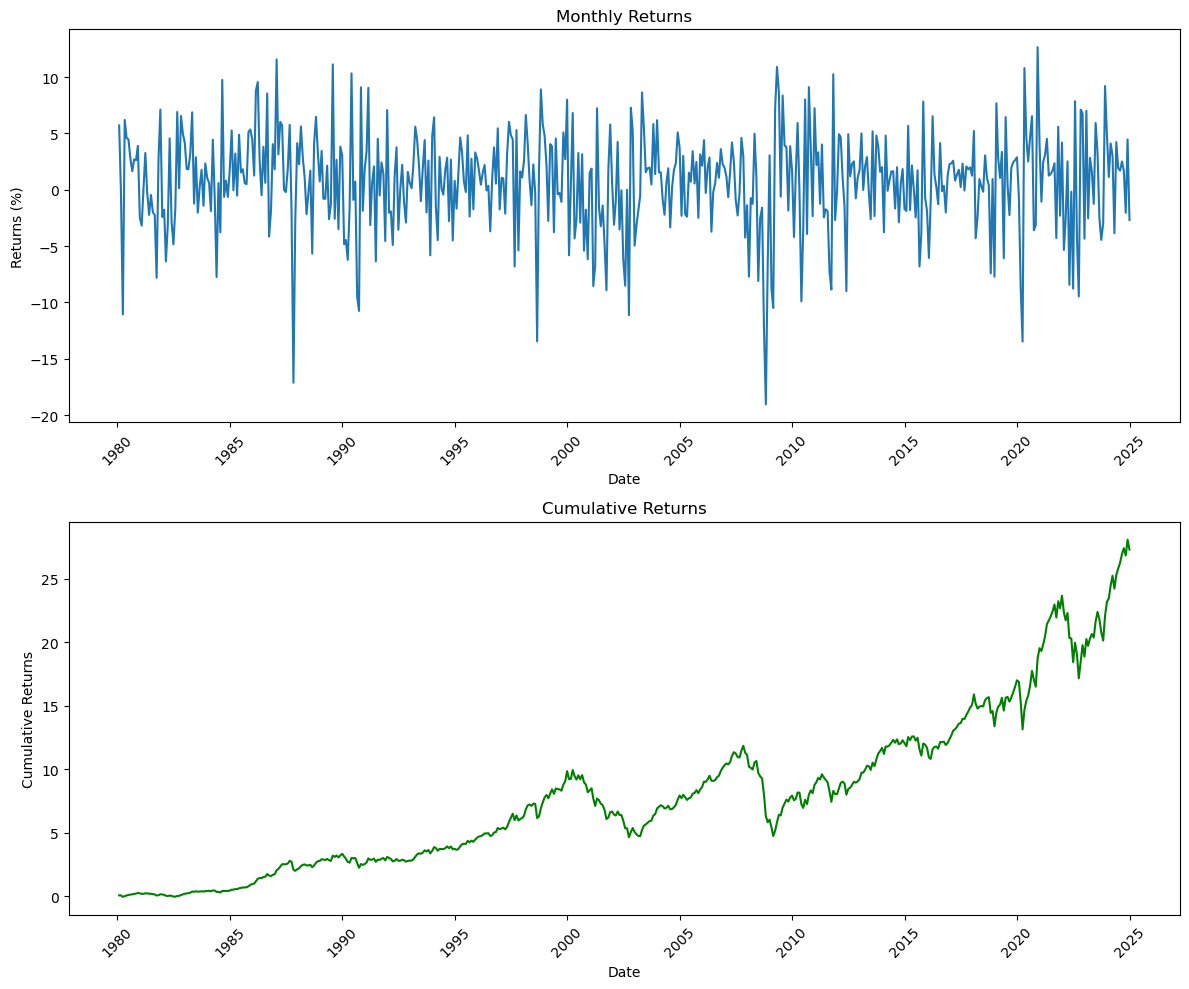

.dMIWO00000PUS    Returns  Cumulative Returns
Date                                         
1979-12-31           <NA>                <NA>
1980-01-31       5.713233            0.057132
1980-02-29      -0.247419            0.054517
1980-03-31     -11.059465           -0.062107
1980-04-30       6.199485           -0.003963


In [8]:
# Plot the returns
title = 'MSCI World Index Monthly and Cumulative Returns (1980-2024)'
fig, ax = plt.subplots(2, 1, figsize=(12,10))

# Monthly Returns Plot
ax[0].plot(msci_world.index, msci_world['Returns'])
ax[0].set_title('Monthly Returns')
ax[0].set_ylabel('Returns (%)')
ax[0].set_xlabel('Date')
ax[0].tick_params(axis='x', rotation=45)

# Cumulative Returns Plot
ax[1].plot(msci_world.index, msci_world['Cumulative Returns'], color='green')
ax[1].set_title('Cumulative Returns')
ax[1].set_ylabel('Cumulative Returns')
ax[1].set_xlabel('Date')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display first few rows
print(msci_world.head())

In [9]:
msci_world.dropna(subset=['Returns'], inplace=True)

msci_world.head()

.dMIWO00000PUS,Returns,Cumulative Returns
Date,,
1980-01-31,5.713233,0.057132
1980-02-29,-0.247419,0.054517
1980-03-31,-11.059465,-0.062107
1980-04-30,6.199485,-0.003963
1980-05-31,4.588096,0.041737


In [10]:
# Calculate the historical volatility (standard deviation) of the MSCI World Index returns
msci_world['Historical Volatility'] = msci_world['Returns'].rolling(window=12).std() * (12 ** 0.5)

In [11]:
# Fit a GARCH(1,1) model to the returns
garch_model = arch_model(msci_world['Returns'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Get the conditional volatility from the GARCH model
msci_world['GARCH Volatility'] = garch_fit.conditional_volatility


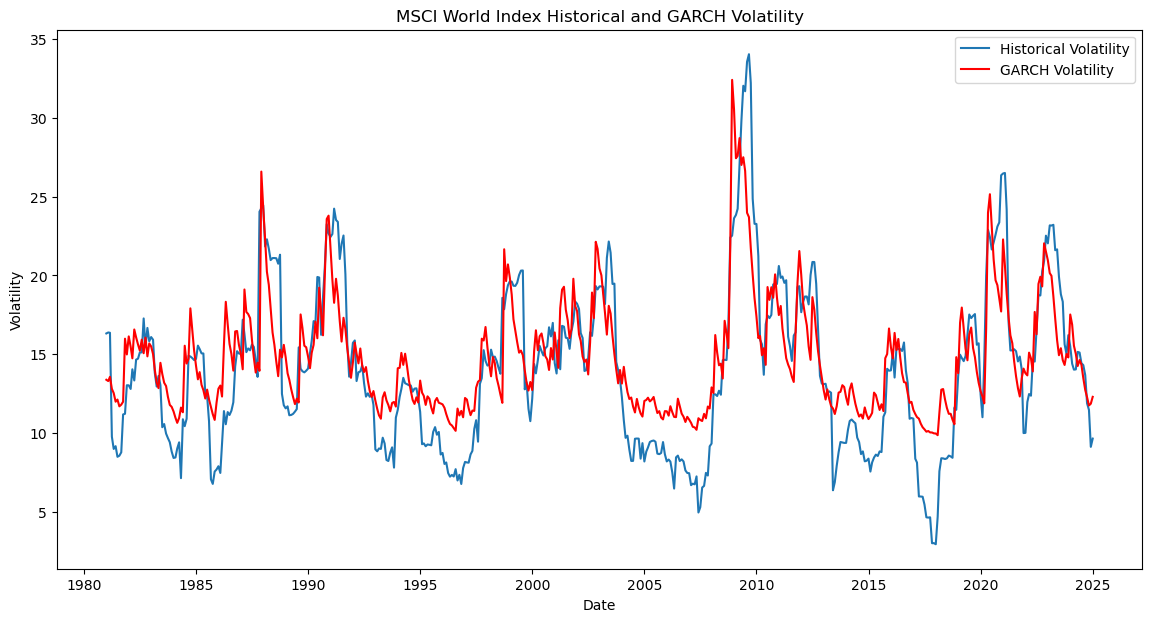

In [12]:
# Calculate Historical Volatility (Rolling 12-month standard deviation)
msci_world['Hist_Volatility'] = msci_world['Returns'].rolling(window=12).std() * (12 ** 0.5)

# Fit a GARCH(1,1) model to the returns
garch_model = arch_model(msci_world['Returns'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Get conditional volatility (annualized)
msci_world['GARCH_Volatility'] = garch_fit.conditional_volatility * (12 ** 0.5)

# Drop any remaining NaN values in the volatility columns
msci_world.dropna(subset=['Hist_Volatility', 'GARCH_Volatility'], inplace=True)

# Plot the volatilities
plt.figure(figsize=(14, 7))
plt.plot(msci_world.index, msci_world['Hist_Volatility'], label='Historical Volatility')
plt.plot(msci_world.index, msci_world['GARCH_Volatility'], label='GARCH Volatility', color='red')
plt.title('MSCI World Index Historical and GARCH Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [13]:
# Align the dataframes by their indices
combined_df = pd.concat([cpi_df['YoY Inflation Rate'], msci_world['Hist_Volatility'], msci_world['GARCH_Volatility']], axis=1).dropna()

In [14]:
combined_df.head()

,YoY Inflation Rate,Hist_Volatility,GARCH_Volatility
1980-12-31,12.353706,16.317340,13.377182
1981-01-31,11.794872,16.379211,13.294553
1981-02-28,11.392405,16.360108,13.561387
1981-03-31,10.611735,9.766265,12.799863
1981-04-30,10.135970,8.988133,12.531402


In [15]:

# Calculate the correlation between YoY inflation and both volatilities
correlation_hist = combined_df[['YoY Inflation Rate', 'Hist_Volatility']].corr().iloc[0, 1]
correlation_garch = combined_df[['YoY Inflation Rate', 'GARCH_Volatility']].corr().iloc[0, 1]

print(f"Correlation between YoY Inflation Rate and Historical Volatility: {correlation_hist}")
print(f"Correlation between YoY Inflation Rate and GARCH Volatility: {correlation_garch}")

Correlation between YoY Inflation Rate and Historical Volatility: -0.06016039937259973
Correlation between YoY Inflation Rate and GARCH Volatility: -0.07564630713524013


In [16]:
# Calculate rolling correlation for each month
rolling_corr_hist = combined_df['YoY Inflation Rate'].rolling(window=12).corr(combined_df['Hist_Volatility'])
rolling_corr_garch = combined_df['YoY Inflation Rate'].rolling(window=12).corr(combined_df['GARCH_Volatility'])

In [17]:
# Count the number of months with positive and negative correlations
positive_corr_hist = (rolling_corr_hist > 0).sum()
negative_corr_hist = (rolling_corr_hist < 0).sum()

positive_corr_garch = (rolling_corr_garch > 0).sum()
negative_corr_garch = (rolling_corr_garch < 0).sum()

print(f"Number of months with positive correlation (Historical Volatility): {positive_corr_hist}")
print(f"Number of months with negative correlation (Historical Volatility): {negative_corr_hist}")

print(f"Number of months with positive correlation (GARCH Volatility): {positive_corr_garch}")
print(f"Number of months with negative correlation (GARCH Volatility): {negative_corr_garch}")

Number of months with positive correlation (Historical Volatility): 213
Number of months with negative correlation (Historical Volatility): 305
Number of months with positive correlation (GARCH Volatility): 212
Number of months with negative correlation (GARCH Volatility): 306


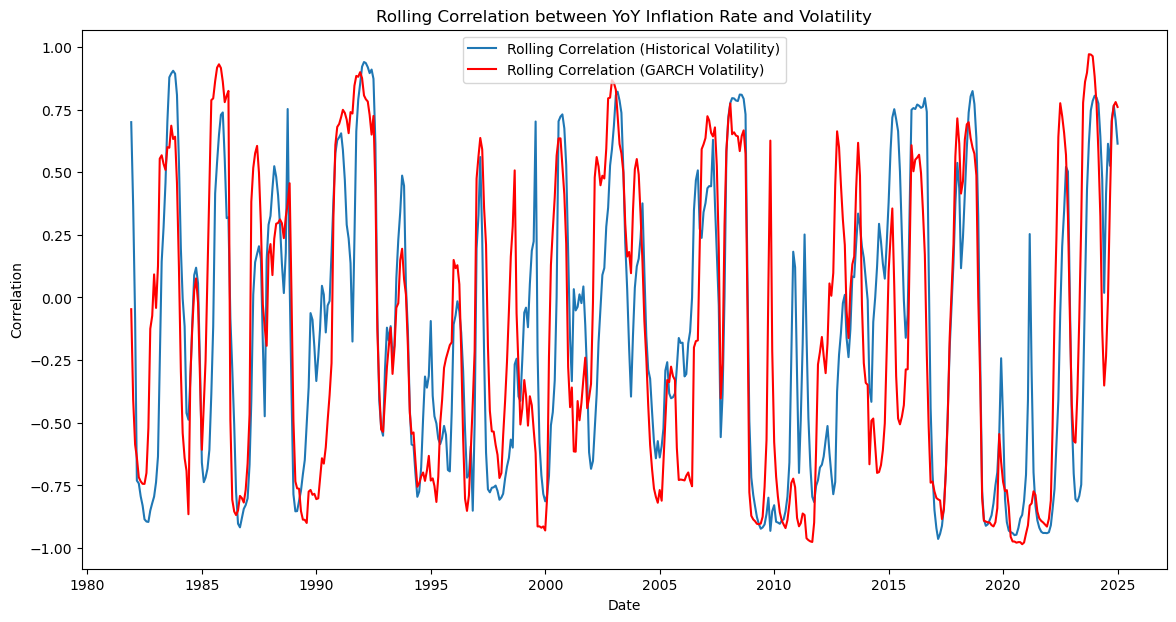

In [18]:
# Plot the rolling correlations
plt.figure(figsize=(14, 7))
plt.plot(rolling_corr_hist, label='Rolling Correlation (Historical Volatility)')
plt.plot(rolling_corr_garch, label='Rolling Correlation (GARCH Volatility)', color='red')
plt.title('Rolling Correlation between YoY Inflation Rate and Volatility')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()

# get expected inflation (professional forecasters survey) and expected volatility (vix world index)

### Descriptive Statistics

 What Assets are we considering? 

 1. S&P500
 2. Russell 2000
 3. Nasdaq
 4. FTSE Index
 5. DAX Index
 6. Stoxx50 Index
 7. Nikkei Index 
 8. Gold
 9. Oil
 10. TIPS
 11. 1 Year Treasury Bill
 12. 10 Year Treasury Bill
 13. REIT O
 14. REIT SPG
 14. USD/EUR
 15. USD/JPY
 16. USD/CHF
 17. Another Commodity?



    sp500_df, russell2000_data, nasdaq_data, FTSE_data, dax_data, stoxx_data, nikkei_data,
    gold_data, oil_data, tips_etf_data, y1_t_bill_df, AMT_data, PLD_data, USD_EUR_data, 
    USD_JPY_data, USD_CHF_data

In [19]:
# Connect to WRDS
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [20]:
# Adjusted query to select S&P 500 returns; omitting `spric` due to undefined column
query = """
    SELECT caldt AS date, sprtrn AS return
    FROM crsp.msp500
    WHERE caldt >= '1979-12-01' AND caldt <= '2024-01-01'
"""
sp500_df = db.raw_sql(query)

# Convert `date` to datetime format for easier handling in pandas
sp500_df['date'] = pd.to_datetime(sp500_df['date'])
sp500_df.set_index('date', inplace=True)

# Display the first few rows of data
print("S&P 500 Monthly Data from CRSP:")
print(sp500_df.head())

S&P 500 Monthly Data from CRSP:
              return
date                
1979-12-31  0.016767
1980-01-31  0.057625
1980-02-29 -0.004380
1980-03-31 -0.101795
1980-04-30  0.041140


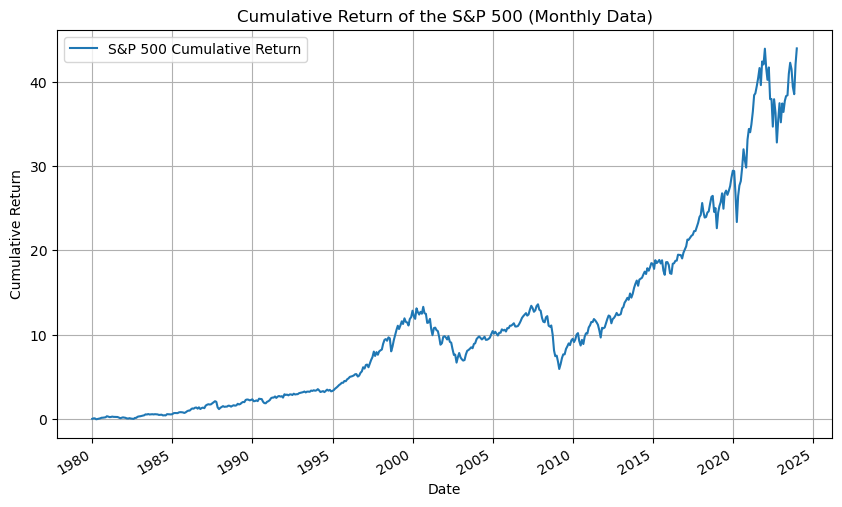

In [21]:
# Rename the columns in sp500_df
sp500_df.rename(columns={'return': 'Monthly Return', 'date': 'Date'}, inplace=True)

sp500_df.head()

# Ensure data is sorted by date
sp500_df.sort_index(inplace=True)

# Calculate cumulative returns (starting from 1, subtract 1 at the end)
sp500_df['Cumulative Return'] = (1 + sp500_df['Monthly Return']).cumprod() - 1

# Plot the cumulative return
plt.figure(figsize=(10, 6))
sp500_df['Cumulative Return'].plot(label="S&P 500 Cumulative Return")
plt.title('Cumulative Return of the S&P 500 (Monthly Data)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Set your App Key
ek.set_app_key('61899440ebae4092ba26deecaf92f2da82521286')

# Define the ticker symbol and parameters for the Russell 2000 index
ticker = '.RUT'  # This is the symbol for the Russell 2000 index

# Retrieve monthly (end-of-month) historical data since January 1, 1984
start_date = '1979-12-01'
end_date = '2024-12-31'

# Request data
try:
    # Use the historical data function with monthly intervals
    russell2000_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'  # Retrieves end-of-month data points
    )
    
    # Display the data
    print(russell2000_data)
except Exception as e:
    print(f"An error occurred: {e}")


.RUT             HIGH      CLOSE        LOW       OPEN  VOLUME
Date                                                          
1979-12-31       <NA>      55.52       <NA>       <NA>    <NA>
1980-01-31       <NA>      60.08       <NA>       <NA>    <NA>
1980-02-29       <NA>      58.81       <NA>       <NA>    <NA>
1980-03-31       <NA>      47.93       <NA>       <NA>    <NA>
1980-04-30       <NA>      50.82       <NA>       <NA>    <NA>
...               ...        ...        ...        ...     ...
2024-08-31  2262.7279  2217.6334  1993.2718  2253.4953    <NA>
2024-09-30  2259.2494    2229.97   2058.684  2206.4118    <NA>
2024-10-31  2289.4888  2196.6525  2170.6131  2223.1187    <NA>
2024-11-30  2466.4854  2434.7257  2200.2976    2202.18    <NA>
2024-12-31  2442.6064  2230.1582  2194.8966  2437.2084    <NA>

[541 rows x 5 columns]


In [23]:
# Calculate monthly returns as percentage change
russell2000_data['Monthly Return'] = russell2000_data['CLOSE'].pct_change()
    
# Calculate cumulative returns
russell2000_data['Cumulative Return'] = (1 + russell2000_data['Monthly Return']).cumprod() - 1
    
# Display the results
print(russell2000_data[['CLOSE', 'Monthly Return', 'Cumulative Return']])

.RUT            CLOSE  Monthly Return  Cumulative Return
Date                                                    
1979-12-31      55.52            <NA>               <NA>
1980-01-31      60.08        0.082133           0.082133
1980-02-29      58.81       -0.021138           0.059258
1980-03-31      47.93       -0.185003          -0.136707
1980-04-30      50.82        0.060296          -0.084654
...               ...             ...                ...
2024-08-31  2217.6334       -0.016346          38.942965
2024-09-30    2229.97        0.005563          39.165166
2024-10-31  2196.6525       -0.014941          38.565067
2024-11-30  2434.7257         0.10838          42.853129
2024-12-31  2230.1582       -0.084021          39.168555

[541 rows x 3 columns]


In [24]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
russell2000_data = russell2000_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
russell2000_data.index.name = 'Date'

# Drop rows with missing values
russell2000_data = russell2000_data.dropna()

# Display the updated DataFrame
print(russell2000_data)

.RUT        Monthly Return  Cumulative Return
Date                                         
1980-01-31        0.082133           0.082133
1980-02-29       -0.021138           0.059258
1980-03-31       -0.185003          -0.136707
1980-04-30        0.060296          -0.084654
1980-05-31        0.079693          -0.011707
...                    ...                ...
2024-08-31       -0.016346          38.942965
2024-09-30        0.005563          39.165166
2024-10-31       -0.014941          38.565067
2024-11-30         0.10838          42.853129
2024-12-31       -0.084021          39.168555

[540 rows x 2 columns]


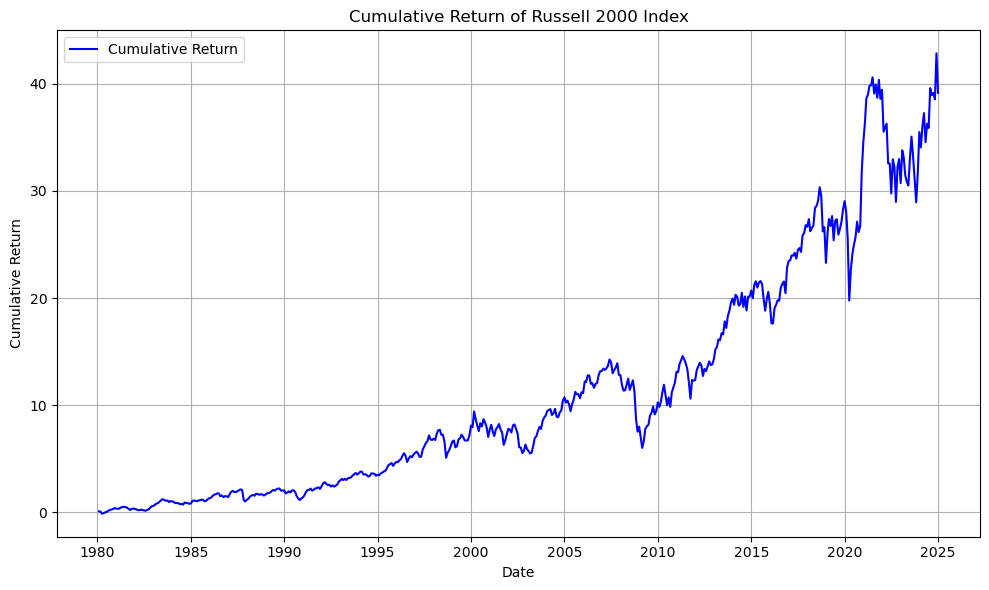

In [25]:
    # Plotting the cumulative returns
    plt.figure(figsize=(10, 6))
    plt.plot(russell2000_data.index, russell2000_data['Cumulative Return'], label='Cumulative Return', color='b')
    plt.title('Cumulative Return of Russell 2000 Index')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [26]:

# Define the ticker symbol for NASDAQ and parameters
ticker = '.IXIC'  # NASDAQ Composite index
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    nasdaq_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    
    # Calculate monthly returns as percentage change
    nasdaq_data['Monthly Return'] = nasdaq_data['CLOSE'].pct_change()
    
    # Calculate cumulative returns
    nasdaq_data['Cumulative Return'] = (1 + nasdaq_data['Monthly Return']).cumprod() - 1
      
    
except Exception as e:
    print(f"An error occurred: {e}")
 
print(nasdaq_data)

.IXIC            HIGH      CLOSE        LOW       OPEN         VOLUME  \
Date                                                                    
1980-03-31       <NA>      131.0       <NA>       <NA>           <NA>   
1980-04-30       <NA>    139.989       <NA>       <NA>           <NA>   
1980-05-31       <NA>    150.449       <NA>       <NA>           <NA>   
1980-06-30       <NA>    157.779       <NA>       <NA>           <NA>   
1980-07-31       <NA>    171.809       <NA>       <NA>           <NA>   
...               ...        ...        ...        ...            ...   
2024-08-31  18017.689  17713.624  15708.537  17647.032  26767776735.0   
2024-09-30   18327.34   18189.17  16668.572  17585.449  23206013904.0   
2024-10-31  18785.495  18095.151  17767.791  18154.939  23323636617.0   
2024-11-30  19366.069  19218.166   18112.83  18189.667  25038500713.0   
2024-12-31  20204.581  19310.792  19168.382  19255.425  29491769366.0   

.IXIC       Monthly Return  Cumulative Return  
Da

c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [27]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
nasdaq_data = nasdaq_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
nasdaq_data.index.name = 'Date'

nasdaq_data = nasdaq_data.dropna()

# Display the updated DataFrame
print(nasdaq_data)

.IXIC       Monthly Return  Cumulative Return
Date                                         
1980-04-30        0.068618           0.068618
1980-05-31         0.07472           0.148466
1980-06-30        0.048721            0.20442
1980-07-31        0.088922           0.311519
1980-08-31        0.056516           0.385641
...                    ...                ...
2024-08-31         0.00649         134.218504
2024-09-30        0.026846         137.848626
2024-10-31       -0.005169         137.130924
2024-11-30        0.062062         145.703557
2024-12-31         0.00482         146.410626

[537 rows x 2 columns]


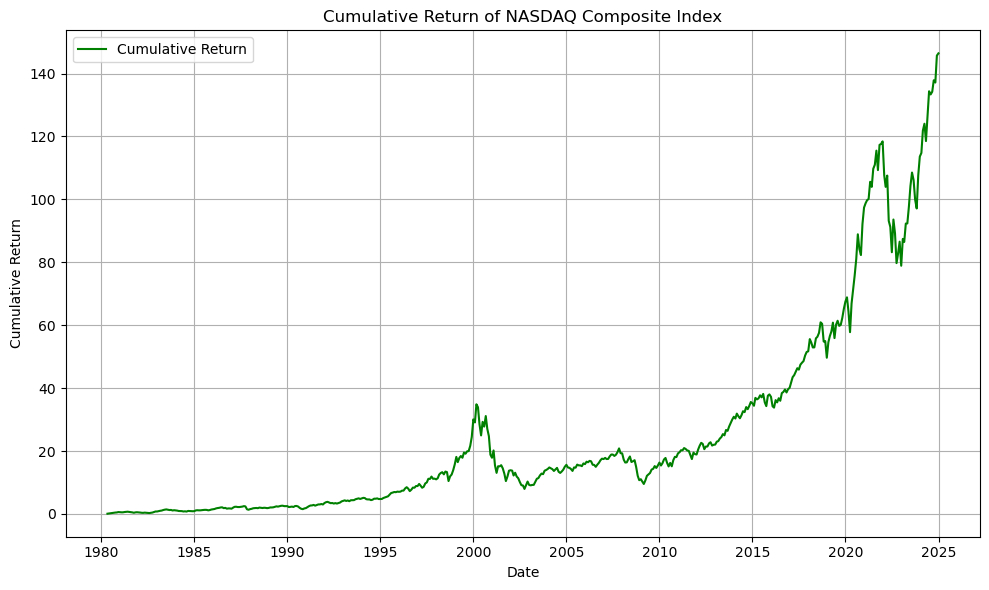

In [28]:
    # Plotting the cumulative returns for NASDAQ
    plt.figure(figsize=(10, 6))
    plt.plot(nasdaq_data.index, nasdaq_data['Cumulative Return'], label='Cumulative Return', color='g')
    plt.title('Cumulative Return of NASDAQ Composite Index')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [29]:
# Define the ticker symbol for the FTSE 100 index and parameters
ticker = '.FTSE'  # FTSE 1000 index symbol
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    FTSE_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print(FTSE_data.head())  # Print the first few rows of the data

except Exception as e:
    print(f"An error occurred: {e}")

.FTSE         HIGH   CLOSE     LOW  OPEN  VOLUME
Date                                            
1984-01-31  1082.0  1063.0   993.3  <NA>    <NA>
1984-02-29  1062.6  1040.3  1010.0  <NA>    <NA>
1984-03-31  1131.3  1112.5  1042.1  <NA>    <NA>
1984-04-30  1138.3  1138.3  1090.0  <NA>    <NA>
1984-05-31  1142.8  1021.0  1008.2  <NA>    <NA>


c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [30]:
# Calculate Cumulative Returns
FTSE_data['Price'] = FTSE_data['CLOSE']  # Assuming 'CLOSE' is the column with closing prices

# Calculate percentage change (returns)
FTSE_data['Monthly Return'] = FTSE_data['Price'].pct_change()

# Calculate cumulative return (compounded)
FTSE_data['Cumulative Return'] = (1 + FTSE_data['Monthly Return']).cumprod() - 1

print(FTSE_data)

.FTSE          HIGH    CLOSE      LOW     OPEN         VOLUME    Price  \
Date                                                                     
1984-01-31   1082.0   1063.0    993.3     <NA>           <NA>   1063.0   
1984-02-29   1062.6   1040.3   1010.0     <NA>           <NA>   1040.3   
1984-03-31   1131.3   1112.5   1042.1     <NA>           <NA>   1112.5   
1984-04-30   1138.3   1138.3   1090.0     <NA>           <NA>   1138.3   
1984-05-31   1142.8   1021.0   1008.2     <NA>           <NA>   1021.0   
...             ...      ...      ...      ...            ...      ...   
2024-08-31  8414.37  8376.63  7915.94  8367.98  17928209678.0  8376.63   
2024-09-30  8380.98  8236.95  8168.42  8376.63  16738909178.0  8236.95   
2024-10-31  8395.58   8110.1  8071.72  8236.95  18650596194.0   8110.1   
2024-11-30  8307.27   8287.3  7995.87   8110.1  17707968777.0   8287.3   
2024-12-31  8388.37  8173.02  8002.34   8287.3  14581691624.0  8173.02   

.FTSE       Monthly Return  Cumulativ

In [31]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
FTSE_data = FTSE_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
FTSE_data.index.name = 'Date'

FTSE_data = FTSE_data.dropna()

# Display the updated DataFrame
print(FTSE_data)

.FTSE       Monthly Return  Cumulative Return
Date                                         
1984-02-29       -0.021355          -0.021355
1984-03-31        0.069403           0.046566
1984-04-30        0.023191           0.070837
1984-05-31       -0.103048          -0.039511
1984-06-30         0.01998           -0.02032
...                    ...                ...
2024-08-31        0.001034           6.880179
2024-09-30       -0.016675           6.748777
2024-10-31         -0.0154           6.629445
2024-11-30        0.021849           6.796143
2024-12-31        -0.01379           6.688636

[491 rows x 2 columns]


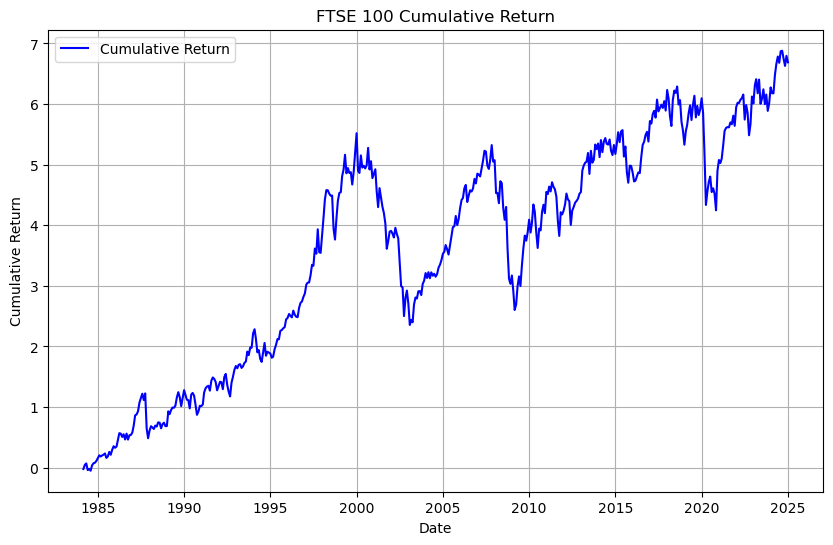

In [32]:
# Plot the cumulative return
plt.figure(figsize=(10, 6))
plt.plot(FTSE_data.index, FTSE_data['Cumulative Return'], label='Cumulative Return', color='blue')
plt.title('FTSE 100 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [33]:
# Define the ticker symbol for DAX 40 index and parameters
ticker = '.GDAXI'  # DAX 40 index symbol (often used in financial data services)
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    dax_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(dax_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully retrieved
.GDAXI      HIGH    CLOSE   LOW  OPEN  VOLUME
Date                                         
1987-12-31  <NA>  1005.19  <NA>  <NA>    <NA>
1988-01-31  <NA>    936.0  <NA>  <NA>    <NA>
1988-02-29  <NA>  1083.34  <NA>  <NA>    <NA>
1988-03-31  <NA>  1062.33  <NA>  <NA>    <NA>
1988-04-30  <NA>  1049.17  <NA>  <NA>    <NA>


c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [34]:
# Calculate Cumulative Returns
dax_data['Price'] = dax_data['CLOSE']  # Assuming 'CLOSE' is the column with closing prices

# Calculate percentage change (returns)
dax_data['Monthly Return'] = dax_data['Price'].pct_change()

# Calculate cumulative return (compounded)
dax_data['Cumulative Return'] = (1 + dax_data['Monthly Return']).cumprod() - 1

print(dax_data)

.GDAXI          HIGH     CLOSE       LOW      OPEN        VOLUME     Price  \
Date                                                                         
1987-12-31      <NA>   1005.19      <NA>      <NA>          <NA>   1005.19   
1988-01-31      <NA>     936.0      <NA>      <NA>          <NA>     936.0   
1988-02-29      <NA>   1083.34      <NA>      <NA>          <NA>   1083.34   
1988-03-31      <NA>   1062.33      <NA>      <NA>          <NA>   1062.33   
1988-04-30      <NA>   1049.17      <NA>      <NA>          <NA>   1049.17   
...              ...       ...       ...       ...           ...       ...   
2024-08-31  18970.71  18906.92  17024.82   18432.5  1019460657.0  18906.92   
2024-09-30  19491.93  19324.93  18208.84  18913.53  1393399482.0  19324.93   
2024-10-31  19674.68  19077.54  18911.72  19409.39  1217257240.0  19077.54   
2024-11-30  19640.15  19626.45  18812.53  19093.99  1415336553.0  19626.45   
2024-12-31  20522.82  19909.14   19568.5  19586.17  1114142924.0

In [35]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
dax_data = dax_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
dax_data.index.name = 'Date'

dax_data = dax_data.dropna()

# Display the updated DataFrame
print(dax_data)

.GDAXI      Monthly Return  Cumulative Return
Date                                         
1988-01-31       -0.068833          -0.068833
1988-02-29        0.157415           0.077746
1988-03-31       -0.019394           0.056845
1988-04-30       -0.012388           0.043753
1988-05-31        0.025249           0.070106
...                    ...                ...
2024-08-31        0.021518            17.8093
2024-09-30        0.022109          18.225151
2024-10-31       -0.012802          17.979039
2024-11-30        0.028773          18.525115
2024-12-31        0.014404          18.806345

[444 rows x 2 columns]


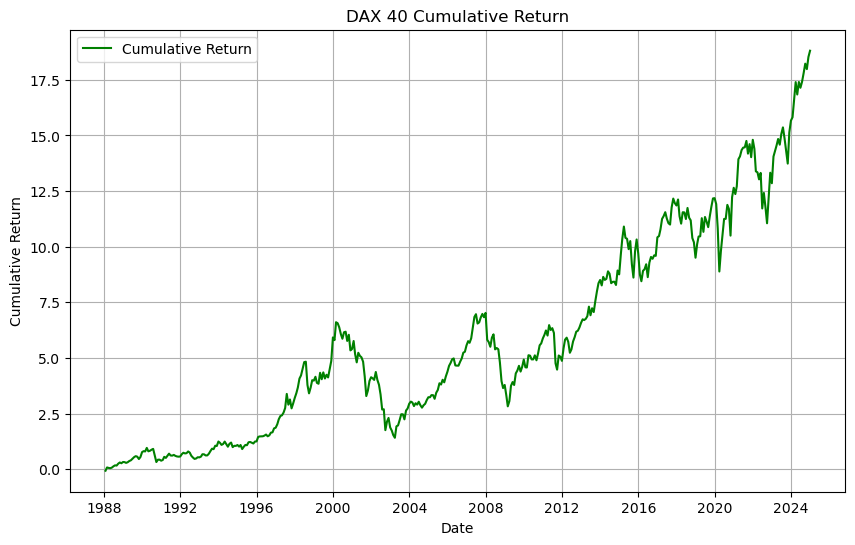

In [36]:
# Plot the cumulative return
plt.figure(figsize=(10, 6))
plt.plot(dax_data.index, dax_data['Cumulative Return'], label='Cumulative Return', color='green')
plt.title('DAX 40 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [37]:
# Define the ticker symbol for the Euro Stoxx 50 index and parameters
ticker = '.STOXX50E'  # Euro Stoxx 50 index symbol in many financial data sources
start_date = '1979-12-01'
end_date = '2024-01-01'

# Retrieve monthly (end-of-month) historical data
try:
    stoxx_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(stoxx_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully retrieved
.STOXX50E     HIGH   CLOSE     LOW    OPEN  VOLUME
Date                                              
1986-12-31  900.82  900.82  900.82  900.82    <NA>
1987-01-31  902.32  859.08   838.6  900.82    <NA>
1987-02-28  849.03  840.97  833.03  849.03    <NA>
1987-03-31  882.89  869.44  836.22   842.7    <NA>
1987-04-30  900.79  881.46  871.69  883.95    <NA>


c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [38]:
# Calculate Cumulative Returns
stoxx_data['Price'] = stoxx_data['CLOSE']  # Assuming 'CLOSE' is the column with closing prices

# Calculate percentage change (returns)
stoxx_data['Monthly Return'] = stoxx_data['Price'].pct_change()

# Calculate cumulative return (compounded)
stoxx_data['Cumulative Return'] = (1 + stoxx_data['Monthly Return']).cumprod() - 1

In [39]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
stoxx_data = stoxx_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
stoxx_data.index.name = 'Date'

stoxx_data = stoxx_data.dropna()

# Display the updated DataFrame
print(stoxx_data)

.STOXX50E   Monthly Return  Cumulative Return
Date                                         
1987-01-31       -0.046336          -0.046336
1987-02-28       -0.021081          -0.066439
1987-03-31        0.033854          -0.034835
1987-04-30        0.013825          -0.021492
1987-05-31       -0.017074          -0.038199
...                    ...                ...
2023-08-31       -0.038959            3.77022
2023-09-30       -0.028496           3.634289
2023-10-31       -0.027197           3.508248
2023-11-30        0.079128           3.864979
2023-12-31         0.03171           4.019249

[444 rows x 2 columns]


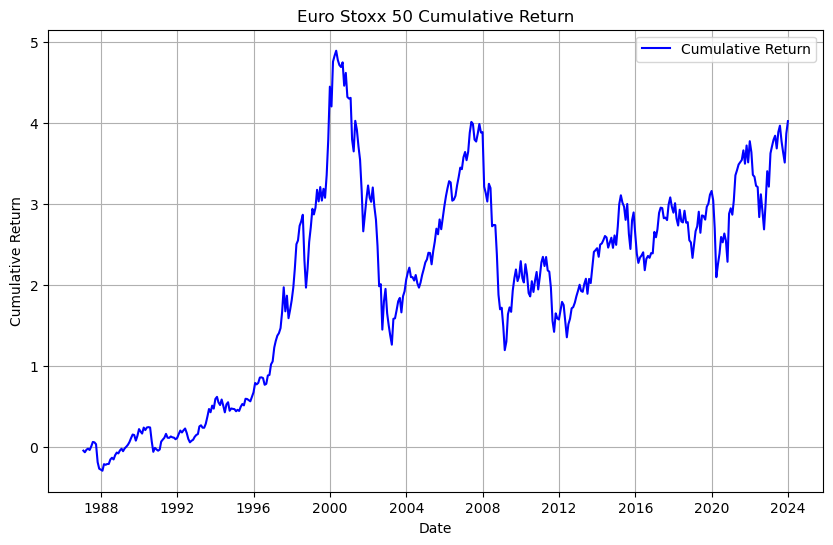

In [40]:
# Plot the cumulative return
plt.figure(figsize=(10, 6))
plt.plot(stoxx_data.index, stoxx_data['Cumulative Return'], label='Cumulative Return', color='blue')
plt.title('Euro Stoxx 50 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [41]:
# List available tables in the 'compd' library
tables = db.list_tables(library='comp')
print("Available tables in compd library:", tables)

Available tables in compd library: ['aco_amda', 'aco_imda', 'aco_indfnta', 'aco_indfntq', 'aco_indfntytd', 'aco_indsta', 'aco_indstq', 'aco_indstytd', 'aco_notesa', 'aco_notesq', 'aco_notessa', 'aco_notesytd', 'aco_pnfnda', 'aco_pnfndq', 'aco_pnfndytd', 'aco_pnfnta', 'aco_pnfntq', 'aco_pnfntytd', 'aco_transa', 'aco_transq', 'aco_transsa', 'aco_transytd', 'adsprate', 'asec_amda', 'asec_imda', 'asec_notesa', 'asec_notesq', 'asec_transa', 'asec_transq', 'bank_aacctchg', 'bank_adesind', 'bank_afnd1', 'bank_afnd2', 'bank_afnddc1', 'bank_afnddc2', 'bank_afntind', 'bank_funda', 'bank_funda_fncd', 'bank_fundq', 'bank_fundq_fncd', 'bank_iacctchg', 'bank_idesind', 'bank_ifndq', 'bank_ifndytd', 'bank_ifntq', 'bank_ifntytd', 'bank_names', 'bank_namesq', 'chars', 'co_aacctchg', 'co_aaudit', 'co_acthist', 'co_adesind', 'co_adjfact', 'co_afnd1', 'co_afnd2', 'co_afnddc1', 'co_afnddc2', 'co_afntind1', 'co_afntind2', 'co_ainvval', 'co_amkt', 'co_busdescl', 'co_cotype', 'co_filedate', 'co_fortune', 'co_h

In [42]:

# Define the query to get data for the Nikkei 225 index from Compustat
query = """
    SELECT
        id_table.tic,
        comp_global_daily.g_idx_mth.datadate AS date,
        id_table.gvkeyx,
        comp_global_daily.g_idx_mth.prccm AS price
    FROM comp_global_daily.g_idx_mth
    INNER JOIN (
        SELECT
            tic,
            gvkeyx
        FROM comp_global_daily.g_names_ix
        WHERE comp_global_daily.g_names_ix.tic IN (
            'I2JPN006'
        )
    ) AS id_table 
    ON comp_global_daily.g_idx_mth.gvkeyx = id_table.gvkeyx
    WHERE comp_global_daily.g_idx_mth.datadate BETWEEN
        '1985-12-01'::date AND '2024-12-31'::date
"""
nikkei_data = db.raw_sql(query)

# Check if the DataFrame is empty
if nikkei_data.empty:
    print("No data found for the specified query.")
else:
    # Convert `date` to datetime format for easier handling in pandas
    nikkei_data['date'] = pd.to_datetime(nikkei_data['date'])
    nikkei_data.set_index('date', inplace=True)

    # Drop rows with missing values
    nikkei_data_cleaned = nikkei_data.dropna()

    # Display the cleaned data
    print("Nikkei 225 Monthly Data from Compustat:")
    print(nikkei_data_cleaned.head())

Nikkei 225 Monthly Data from Compustat:
                 tic  gvkeyx     price
date                                  
1985-12-31  I2JPN006  150069  13083.18
1986-01-31  I2JPN006  150069  13024.30
1986-02-28  I2JPN006  150069  13640.83
1986-03-31  I2JPN006  150069  15859.69
1986-04-30  I2JPN006  150069  15825.50


In [43]:
# Calculate monthly returns
nikkei_data['Monthly Return'] = nikkei_data['price'].pct_change()

# Calculate cumulative returns
nikkei_data['Cumulative Return'] = (1 + nikkei_data['Monthly Return']).cumprod() - 1

# Drop rows with missing values in 'Monthly Return'
nikkei_data.dropna(subset=['Monthly Return'], inplace=True)

# Display the data with cumulative return
print(nikkei_data[['price', 'Monthly Return', 'Cumulative Return']].head())

               price  Monthly Return  Cumulative Return
date                                                   
1986-01-31  13024.30       -0.004500          -0.004500
1986-02-28  13640.83        0.047337           0.042623
1986-03-31  15859.69        0.162663           0.212220
1986-04-30  15825.50       -0.002156           0.209607
1986-05-31  16670.77        0.053412           0.274214


In [44]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
nikkei_data = nikkei_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
nikkei_data.index.name = 'Date'

# Display the updated DataFrame
print(nikkei_data)

            Monthly Return  Cumulative Return
Date                                         
1986-01-31       -0.004500          -0.004500
1986-02-28        0.047337           0.042623
1986-03-31        0.162663           0.212220
1986-04-30       -0.002156           0.209607
1986-05-31        0.053412           0.274214
...                    ...                ...
2024-08-31       -0.011613           1.954003
2024-09-30       -0.018842           1.898344
2024-10-31        0.030636           1.987137
2024-11-30       -0.022344           1.920393
2024-12-31        0.044140           2.049300

[468 rows x 2 columns]


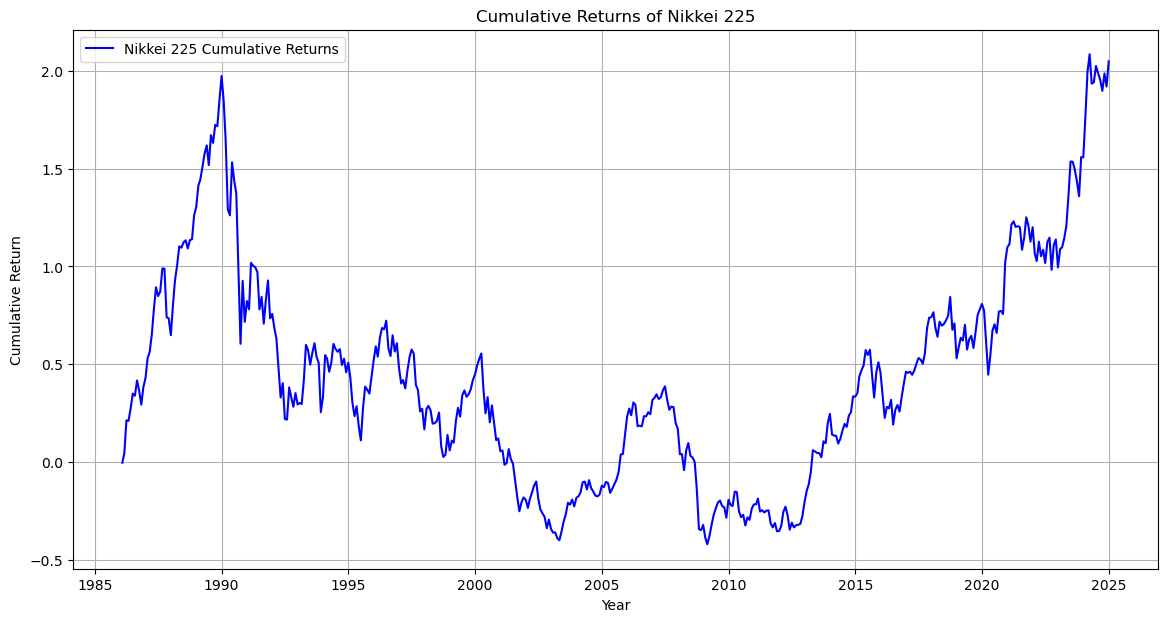

In [45]:
# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(nikkei_data.index, nikkei_data['Cumulative Return'], label='Nikkei 225 Cumulative Returns', color='b')
plt.title('Cumulative Returns of Nikkei 225')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Define the ticker symbol for Realty Income Corp and parameters
ticker = 'O'
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    realty_income_data = ek.get_timeseries(
        ticker,
        fields='CLOSE',
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(realty_income_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully retrieved
O              CLOSE
Date                
1994-10-31  8.049667
1994-11-30  7.747048
1994-12-31  8.291762
1995-01-31  8.594381
1995-02-28   9.19962


In [61]:
# Define the ticker symbol for Simon Property Group and parameters
ticker = 'SPG'
start_date = '1979-12-01'
end_date = '2024-01-01'

# Retrieve monthly (end-of-month) historical data
try:
    spg_data = ek.get_timeseries(
        ticker,
        fields='CLOSE',
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(spg_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")



Data successfully retrieved
SPG             CLOSE
Date                 
1993-12-31  20.312647
1994-01-31  21.996016
1994-02-28  23.118261
1994-03-31  23.006037
1994-04-30  24.016058


In [62]:
# Compute monthly returns
spg_data['Monthly Return'] = spg_data['CLOSE'].pct_change()
realty_income_data['Monthly Return'] = realty_income_data['CLOSE'].pct_change()

# Compute cumulative returns
spg_data['Cumulative Return'] = (1 + spg_data['Monthly Return']).cumprod() - 1
realty_income_data['Cumulative Return'] = (1 + realty_income_data['Monthly Return']).cumprod() - 1

spg_data.head()



SPG,CLOSE,Monthly Return,Cumulative Return
Date,,,
1993-12-31,20.312647,<NA>,<NA>
1994-01-31,21.996016,0.082873,0.082873
1994-02-28,23.118261,0.05102,0.138122
1994-03-31,23.006037,-0.004854,0.132597
1994-04-30,24.016058,0.043902,0.18232


In [63]:
realty_income_data.head()

O,CLOSE,Monthly Return,Cumulative Return
Date,,,
1994-10-31,8.049667,<NA>,<NA>
1994-11-30,7.747048,-0.037594,-0.037594
1994-12-31,8.291762,0.070313,0.030075
1995-01-31,8.594381,0.036496,0.067669
1995-02-28,9.19962,0.070423,0.142857


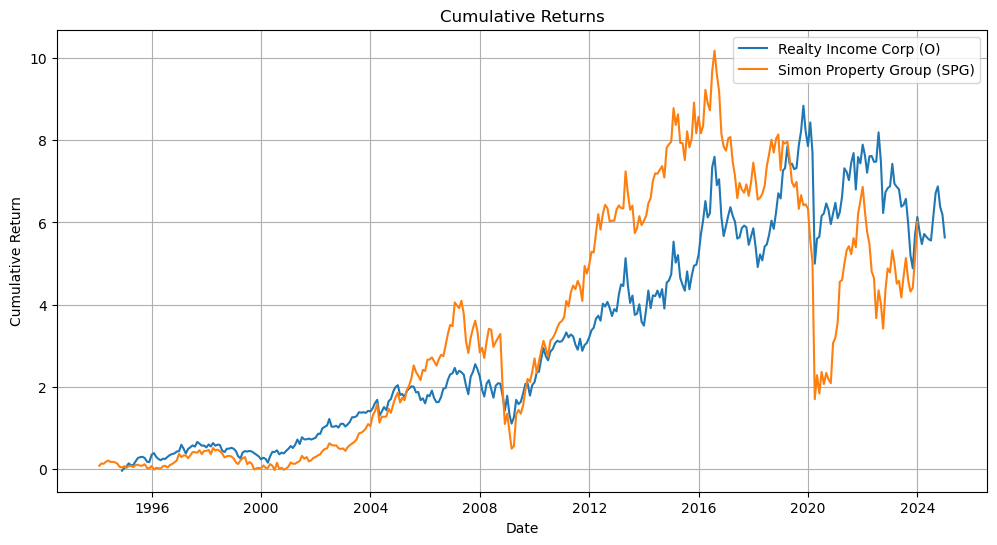

In [64]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(realty_income_data.index, realty_income_data['Cumulative Return'], label='Realty Income Corp (O)')
plt.plot(spg_data.index, spg_data['Cumulative Return'], label='Simon Property Group (SPG)')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
ticker = 'XAU='  

# Retrieve historical data for gold prices from 1945 to present
gold_data = ek.get_timeseries(ticker, start_date='1979-12-01', end_date='2024-12-31', interval='monthly')

# Ensure data is sorted by date
gold_data.sort_index(inplace=True)

# Calculate Monthly Returns
gold_data['Monthly Return'] = gold_data['CLOSE'].pct_change()

# Calculate Cumulative Returns
gold_data['Cumulative Return'] = (1 + gold_data['Monthly Return']).cumprod()-1

gold_data.head()

XAU=,CLOSE,HIGH,LOW,OPEN,Monthly Return,Cumulative Return
Date,,,,,,
1979-12-31,512.0,515.5,429.0,429.0,<NA>,<NA>
1980-01-31,653.0,835.0,512.0,512.0,0.275391,0.275391
1980-02-29,637.0,710.5,616.5,676.5,-0.024502,0.244141
1980-03-31,495.0,663.75,481.5,663.75,-0.22292,-0.033203
1980-04-30,518.0,554.0,485.75,509.5,0.046465,0.011719


In [66]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
gold_data = gold_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
gold_data.index.name = 'Date'

# Display the updated DataFrame
print(gold_data)

XAU=        Monthly Return  Cumulative Return
Date                                         
1979-12-31            <NA>               <NA>
1980-01-31        0.275391           0.275391
1980-02-29       -0.024502           0.244141
1980-03-31        -0.22292          -0.033203
1980-04-30        0.046465           0.011719
...                    ...                ...
2024-08-31        0.022439           3.888735
2024-09-30        0.052521           4.145496
2024-10-31        0.041492           4.358994
2024-11-30       -0.032895           4.182707
2024-12-31       -0.011205           4.124633

[541 rows x 2 columns]


Text(0.5, 0, 'Year')

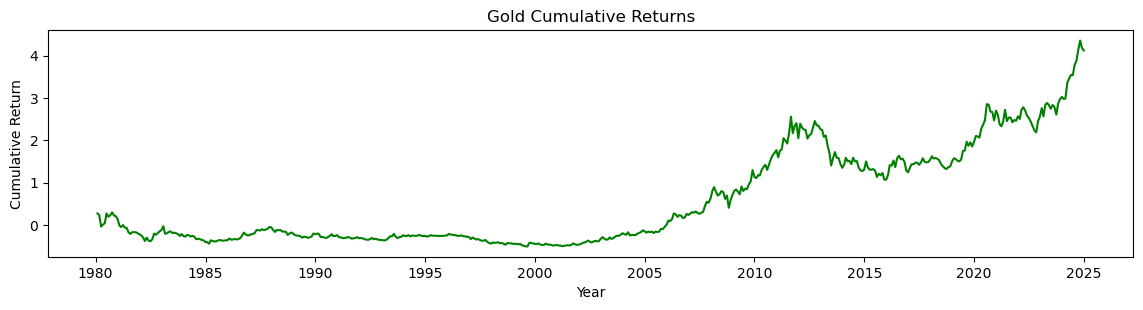

In [68]:
# Plotting the Gold Prices, Monthly Returns, and Cumulative Returns
plt.figure(figsize=(14, 10))


# Plot the cumulative returns
plt.subplot(3, 1, 3)
plt.plot(gold_data.index, gold_data['Cumulative Return'], color='green')
plt.title('Gold Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Year')

In [ ]:
# Define the instrument (West Texas Intermediate Oil)
ticker = 'CLc1'  # CLc1 is the RIC for WTI Crude Oil in USD per barrel

# Retrieve historical data for oil prices from 1945 to present
oil_data = ek.get_timeseries(ticker, start_date='1945-01-01', end_date='2024-01-01', interval='monthly')

# Ensure data is sorted by date
oil_data.sort_index(inplace=True)

# Calculate Monthly Returns
oil_data['Monthly Return'] = oil_data['CLOSE'].pct_change()

# Calculate Cumulative Returns
oil_data['Cumulative Return'] = (1 + oil_data['Monthly Return']).cumprod() - 1

# Display the first few rows of the data
oil_data.head()

CLc1,HIGH,LOW,OPEN,CLOSE,VOLUME,Monthly Return,Cumulative Return
Date,,,,,,,
1983-03-31,29.6,29.01,29.25,29.27,1470,<NA>,<NA>
1983-04-30,31.0,29.29,29.3,30.63,5961,0.046464,0.046464
1983-05-31,30.72,29.25,30.66,30.25,4079,-0.012406,0.033481
1983-06-30,31.65,30.1,30.35,31.38,4535,0.037355,0.072087
1983-07-31,32.02,31.0,31.42,32.0,4685,0.019758,0.09327


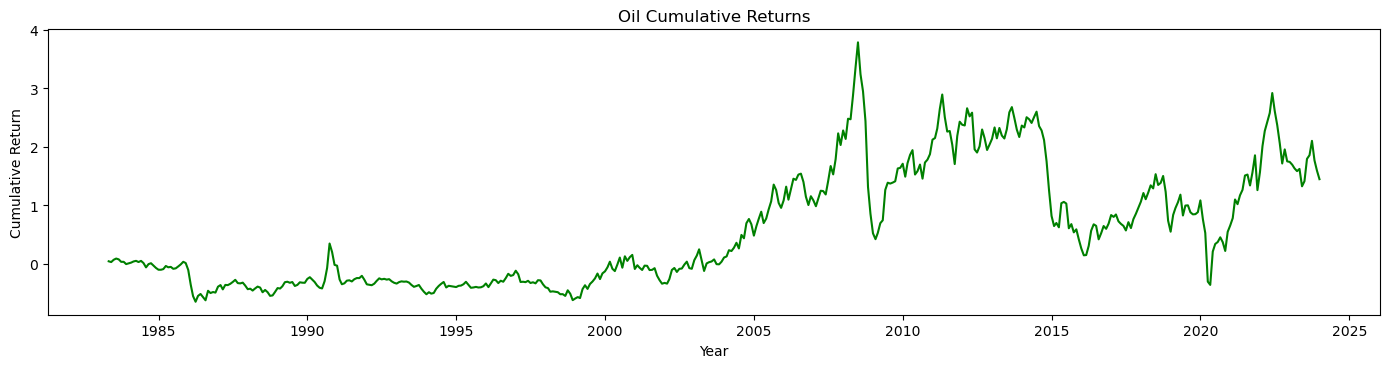

In [74]:
#Plotting the Oil Prices, Monthly Returns, and Cumulative Returns
plt.figure(figsize=(14, 10))


# Plot the cumulative returns
plt.subplot(3, 1, 3)
plt.plot(oil_data.index, oil_data['Cumulative Return'], color='green')
plt.title('Oil Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Year')

plt.tight_layout()
plt.show()

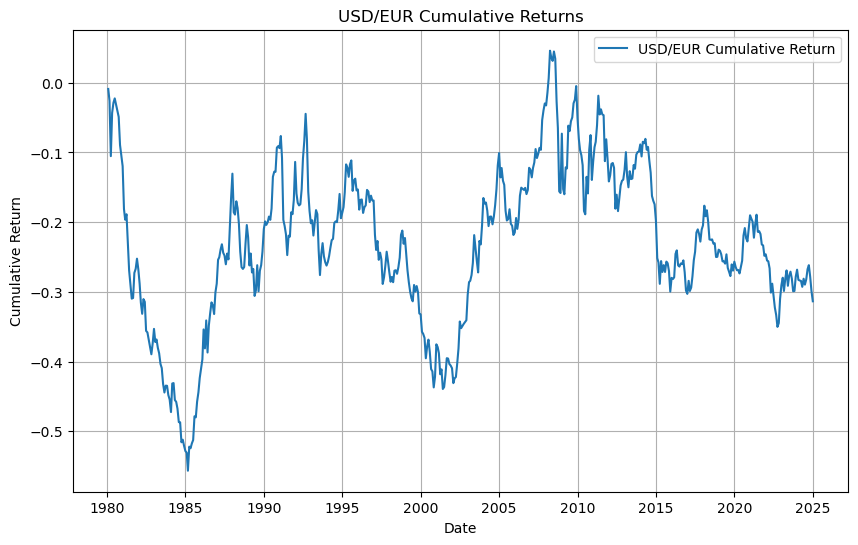

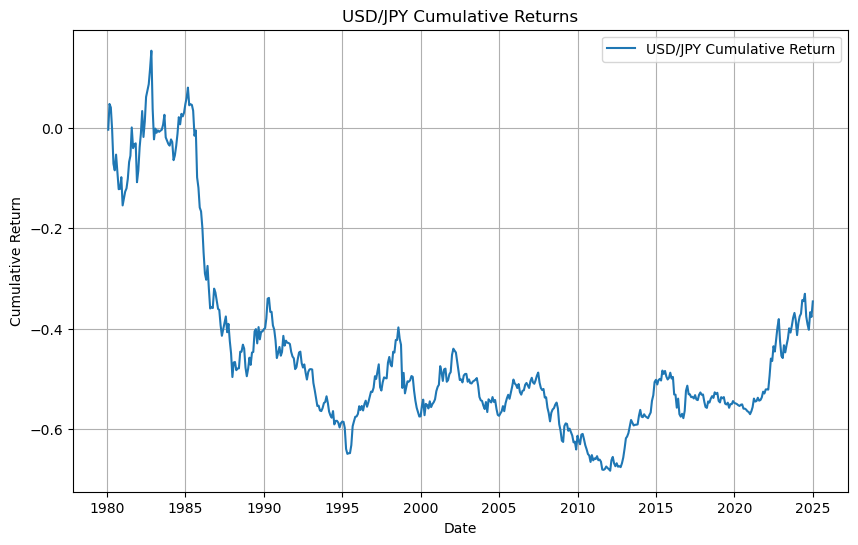

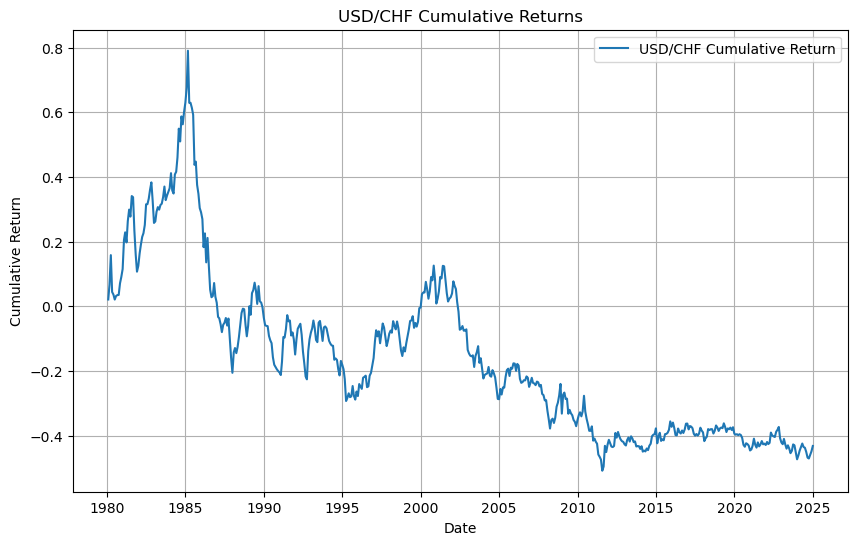

In [82]:

# Define the tickers for FX pairs
tickers = {
    'USD/EUR': 'EUR=',
    'USD/JPY': 'JPY=',
    'USD/CHF': 'CHF='
}

# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Loop through each FX pair, retrieve the data, and calculate returns
for name, ticker in tickers.items():
    # Retrieve FX rate data from Refinitiv
    data = ek.get_timeseries(
        ticker, 
        start_date=start_date, 
        end_date=end_date, 
        interval='monthly'
    )
    data.sort_index(inplace=True)

    # Ensure the data is a DataFrame and calculate monthly and cumulative returns
    data = pd.DataFrame(data)
    data['Monthly Return'] = data['CLOSE'].pct_change()
    data['Cumulative Return'] = (1 + data['Monthly Return']).cumprod()-1

    # Keep only the Date index and the relevant columns
    data = data[['Monthly Return', 'Cumulative Return']]
    
    # Assign the final DataFrame to a dynamically created variable
    globals()[f"{name.replace('/', '_')}_data"] = data

    # Plot the cumulative returns
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Cumulative Return'], label=f'{name} Cumulative Return')
    plt.title(f'{name} Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid()
    plt.show()


C:\Users\geral\AppData\Local\Temp\ipykernel_15740\1937847651.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfii10_data[series_id].replace(0, 1e-10, inplace=True)
C:\Users\geral\AppData\Local\Temp\ipykernel_15740\1937847651.py:18: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  dfii10_data['Monthly Return'] = dfii10_data[series

            DFII10  Monthly Return  Cumulative Return
DATE                                                 
2003-01-02    2.43             NaN                NaN
2003-01-03    2.43        0.000000           0.000000
2003-01-06    2.46        0.012346           0.012346
2003-01-07    2.42       -0.016260          -0.004115
2003-01-08    2.29       -0.053719          -0.057613


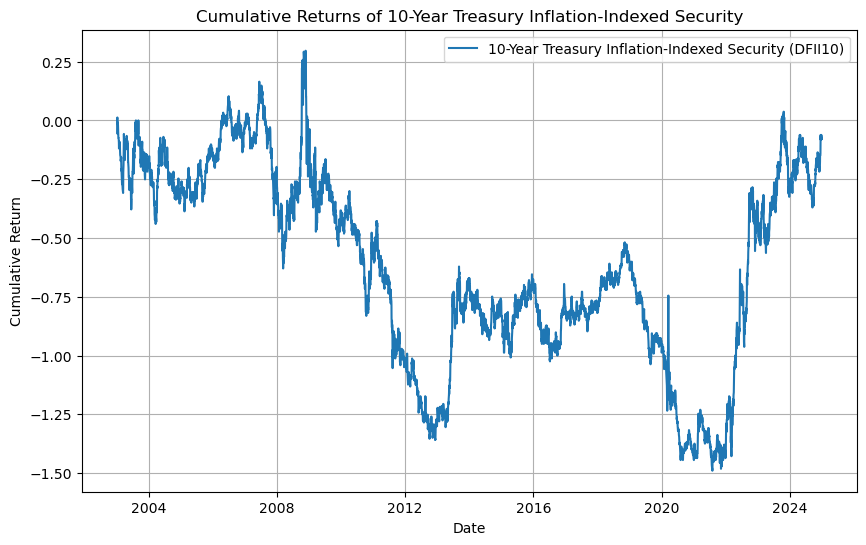

In [90]:
# Define the FRED series ID for the 10-Year Treasury Inflation-Indexed Security
series_id = 'DFII10'

# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Retrieve the data from FRED
dfii10_data = web.DataReader(series_id, 'fred', start_date, end_date)

# Ensure the data is sorted by date
dfii10_data.sort_index(inplace=True)

# Replace 0 yields with a small value
dfii10_data[series_id].replace(0, 1e-10, inplace=True)

# Calculate Monthly Returns based on yield changes
dfii10_data['Monthly Return'] = dfii10_data[series_id].pct_change()

# Calculate Cumulative Returns
dfii10_data['Cumulative Return'] = (1 + dfii10_data['Monthly Return']).cumprod() - 1

# Display the first few rows of the data
print(dfii10_data.head())

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(dfii10_data.index, dfii10_data['Cumulative Return'], label='10-Year Treasury Inflation-Indexed Security (DFII10)')
plt.title('Cumulative Returns of 10-Year Treasury Inflation-Indexed Security')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

In [89]:
dfii10_data.to_csv('dfii10_data.csv')

In [ ]:
# Define the instrument
ticker = 'TIP'  

tip_etf_data = ek.get_timeseries(ticker, start_date='1979-12-31', end_date='2024-12-31', interval='monthly')

# Ensure data is sorted by date
tip_etf_data.sort_index(inplace=True)

# Calculate Monthly Returns
tip_etf_data['Monthly Return'] = tip_etf_data['CLOSE'].pct_change()

# Calculate Cumulative Returns
tip_etf_data['Cumulative Return'] = (1 + tip_etf_data['Monthly Return']).cumprod() - 1

# Display the first few rows of the data
tip_etf_data.head()

TIP,HIGH,CLOSE,LOW,OPEN,COUNT,VOLUME,Monthly Return,Cumulative Return
Date,,,,,,,,
2003-12-31,102.34,101.71,101.47,101.5,<NA>,1814700,<NA>,<NA>
2004-01-31,103.72,102.95,101.08,101.5,<NA>,3035200,0.012192,0.012192
2004-02-29,105.22,105.16,102.81,102.98,<NA>,2811400,0.021467,0.03392
2004-03-31,107.67,106.91,105.02,105.47,<NA>,3088300,0.016641,0.051126
2004-04-30,106.43,101.26,100.8,106.25,<NA>,2343900,-0.052848,-0.004424


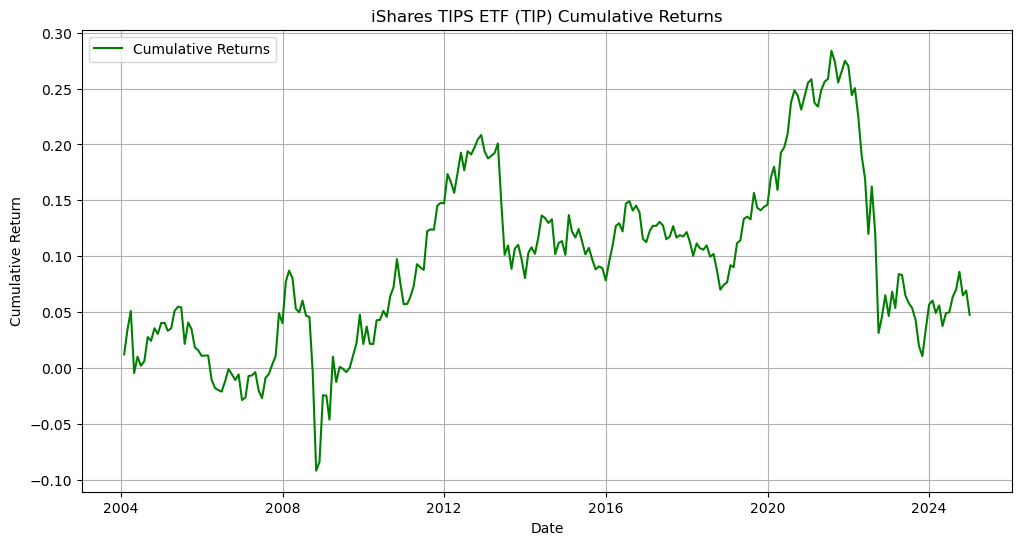

In [85]:
# Plot Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(tip_etf_data.index, tip_etf_data['Cumulative Return'], label='Cumulative Returns', color='green')
plt.title('iShares TIPS ETF (TIP) Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

             GS10  Monthly Return  Cumulative Return
DATE                                                
1979-12-01  10.39             NaN                NaN
1980-01-01  10.80        0.039461           0.039461
1980-02-01  12.41        0.149074           0.194418
1980-03-01  12.75        0.027397           0.227141
1980-04-01  11.47       -0.100392           0.103946


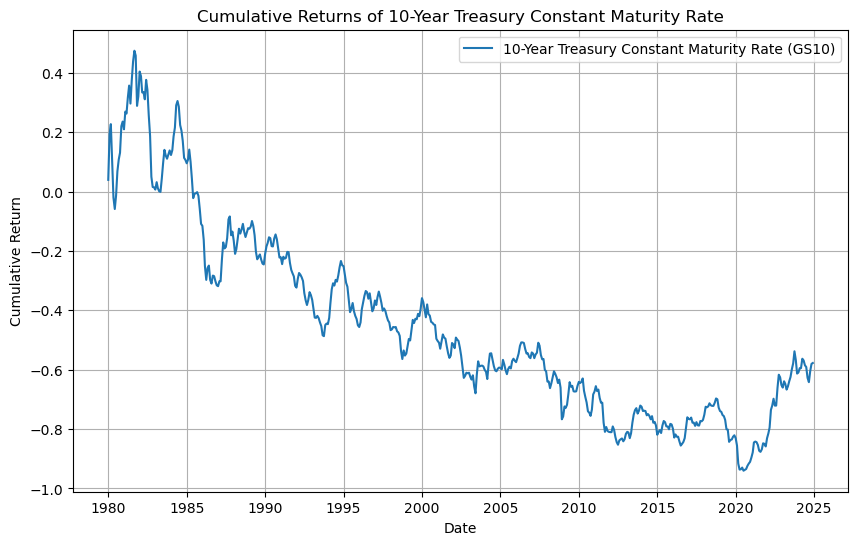

In [92]:
# Define the FRED series ID for the 10-Year Treasury Constant Maturity Rate
series_id = 'GS10'

# Set the date range
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve the data from FRED
gs10_data = web.DataReader(series_id, 'fred', start_date, end_date)

# Ensure the data is sorted by date
gs10_data.sort_index(inplace=True)


# Calculate Monthly Returns based on yield changes
gs10_data['Monthly Return'] = gs10_data[series_id].pct_change()


# Calculate Cumulative Returns
gs10_data['Cumulative Return'] = (1 + gs10_data['Monthly Return']).cumprod() - 1

# Display the first few rows of the data
print(gs10_data.head())

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(gs10_data.index, gs10_data['Cumulative Return'], label='10-Year Treasury Constant Maturity Rate (GS10)')
plt.title('Cumulative Returns of 10-Year Treasury Constant Maturity Rate')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

# Expected Inflation (10Year Breakeven OR Survey?) & Expected Volatility

Expected inflation as in 10 Year Breakeven - The breakeven inflation rate represents a measure of expected inflation derived from 10-Year Treasury Constant Maturity Securities (BC_10YEAR) and 10-Year Treasury Inflation-Indexed Constant Maturity Securities (TC_10YEAR). The latest value implies what market participants expect inflation to be in the next 10 years, on average.

In [93]:
# Download 10-Year Breakeven Inflation Rate data from FRED
breakeven_inflation_data = fred.get_series('T10YIE')
breakeven_inflation_df = pd.DataFrame(breakeven_inflation_data, columns=['Expected Inflation Rate'])
breakeven_inflation_df.index = pd.to_datetime(breakeven_inflation_df.index)

# Display head of the data
breakeven_inflation_df.head()

,Expected Inflation Rate
2003-01-02,1.64
2003-01-03,1.62
2003-01-06,1.63
2003-01-07,1.62
2003-01-08,1.71


University of Michigan Inflation Expectation: Median expected price change next 12 months, Surveys of Consumers.

In [95]:
# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Fetch University of Michigan Inflation Expectations (MICH) from FRED
umich_inflation = web.DataReader("MICH", "fred", start_date, end_date)

# Resample to end-of-month data
umich_inflation = umich_inflation.resample('M').last()

# Rename the column for clarity
umich_inflation.rename(columns={"MICH": "UMich Expected Inflation Rate"}, inplace=True)

# Drop any missing values
umich_inflation.dropna(inplace=True)

# Display the first few rows
print(umich_inflation.head())

            UMich Expected Inflation Rate
DATE                                     
1980-01-31                           10.4
1980-02-29                           10.0
1980-03-31                           10.2
1980-04-30                           10.1
1980-05-31                            8.6


C:\Users\geral\AppData\Local\Temp\ipykernel_15740\2671680920.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  umich_inflation = umich_inflation.resample('M').last()


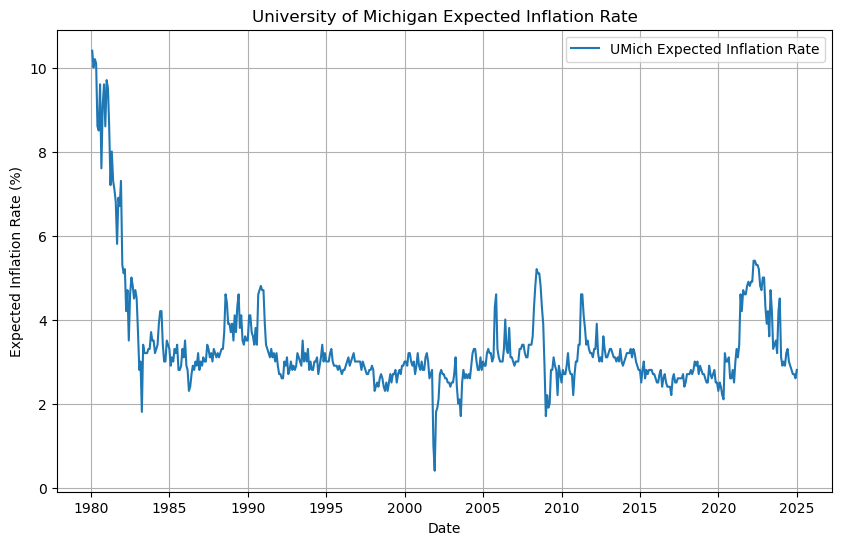

In [96]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(umich_inflation.index, umich_inflation['UMich Expected Inflation Rate'], label='UMich Expected Inflation Rate')
plt.title('University of Michigan Expected Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Expected Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

# Summary Statistics